In [1]:
import os
# ignore 1 million tensorflow warnings, comment out if you run into errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.phosphene_model import RectangleImplant, MVGModel
from src.DSE import fetch_dse, load_mnist, rand_model_params, sample_cn_characters, enhance_casia_images, load_emnist, load_character_images
from src.HILO import HILOPatient, patient_from_phi_arr

## DSE Evaluation: CASIA

In [ ]:
version='v2' # version from paper, with bug fixed.
implant = RectangleImplant()
model = MVGModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.5).build()
dse = fetch_dse(model, implant, version=version)
# (targets, labels), (targets_test, labels_test) = sample_cn_characters(model, "assets/Gnt1.1Test/", 10000)
(targets, labels), (targets_test, labels_test) = load_character_images(model)
phi = rand_model_params(len(targets_test), version=version)

In [28]:
dse.evaluate((targets_test, phi), targets_test)

313/313 [==============================] - 100s 309ms/step - loss: 0.1348


0.13475239276885986

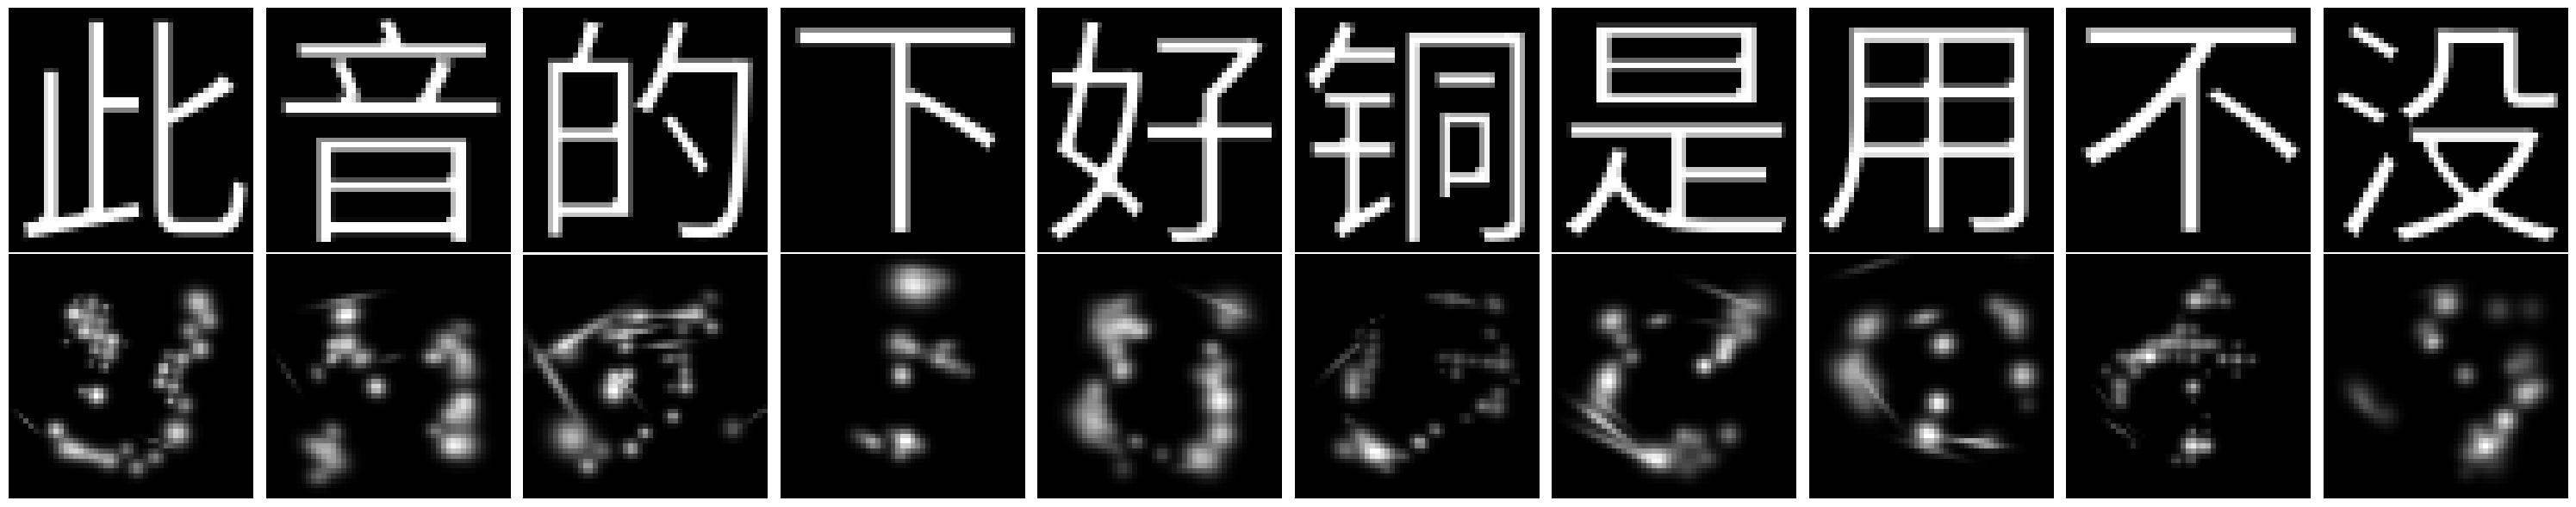

In [29]:
nimgs = 10
predicted_percepts = dse([targets_test[:nimgs], phi[:nimgs]])
fig, axes = plt.subplots(2, nimgs, figsize=(nimgs*3, 6))
for idx, (pred, target) in enumerate(zip(predicted_percepts, targets_test[:nimgs])): 
    axes[0, idx].imshow(target, cmap='gray')
    axes[1, idx].imshow(pred, cmap='gray')
# make it look nice
for ax in axes.ravel():
    ax.axis('off')
fig.tight_layout()

## Human-in-the-Loop Optimization

Here, we show an example of how to use HILO with simulated patients. 

Note that Bayesian optimization uses Matlab. Thus you must have Matlab and the Matlab python extension installed, which must be installed separately from requirements.txt (see readme)

In [30]:
phis = rand_model_params(len(targets_test), version=version)

# run for the first patient
phi = phis[0]
matlab_dir = 'matlab/'
# get a true model corresponding to the patient specified by phi
model, implant = patient_from_phi_arr(phi, model, implant, implant_kwargs={})
patient = HILOPatient(model, implant, dse=dse, phi_true=phi, matlab_dir=matlab_dir, version=version)

The following function runs HILO optimization on a patient for n duels

In [31]:
def run_hilo(patient, num_duels):
    d = patient.d
    xtrain = np.empty((d*2, num_duels), dtype='double') # phi1/phi2 used in duels
    ctrain = np.empty((num_duels), dtype='double') # responses
    losses = []
    
    pbar = tqdm(range(num_duels), unit='duels')
    for idx_duel in pbar:
        if idx_duel == 0:
            xtrain[:, idx_duel] = patient.hilo_acquisition(None, None)
        else:
            xtrain[:, idx_duel] = patient.hilo_acquisition(xtrain[:, :idx_duel], ctrain[:idx_duel])
        phi1 = xtrain[:d, idx_duel]
        phi2 = xtrain[d:, idx_duel]

        target = targets_test[np.random.randint(0, len(targets_test))] # get a random target
        # simulate the duel
        decision, resdict = patient.duel(target, phi1, phi2)
        ctrain[idx_duel] = decision
        # update posterior
        patient.hilo_update_posterior(xtrain[:, :idx_duel+1], ctrain[:idx_duel+1])
        # get the current best guess for true phi
        phi_guess = patient.hilo_identify_best(xtrain[:, :idx_duel+1], ctrain[:idx_duel+1])
        
        # for example here, only evaluate on subset of test set to save time
        nsamples = 256 * 4
        dse_loss = patient.mismatch_dse.evaluate(x=[targets_test[:nsamples], tf.repeat(phi_guess[None, ...], nsamples, axis=0)], 
                                                 y=targets_test[:nsamples], batch_size=256, verbose=0)
        losses.append(dse_loss)
        pbar.set_description(f"loss: {dse_loss : .4f}")
    return phi_guess, losses

Now we can run the patient. This can take a while, mainly due to evaluating the DSE loss at every iteration, but also due to running the acquisition function for new $\phi$. The loss might not change for a number of duels. This is because HILO is exploring new candidate phi, but often this exploration takes a while to be fruitful (up to ~20 duels).

In [32]:
best_phi, losses = run_hilo(patient, 100)

  0%|          | 0/100 [00:00<?, ?duels/s]

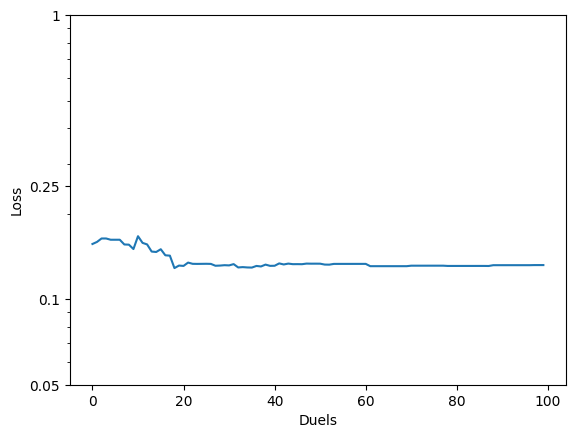

In [33]:
# view the results
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Duels")
plt.ylabel("Loss")
plt.yscale('log')
plt.yticks([0.05, 0.1, 0.25, 1], labels =[str(i) for i in [0.05, 0.1, 0.25, 1]])
plt.show()

We can use the patients mismatch_dse to view the resulting percepts, encoded with our best guess for phi

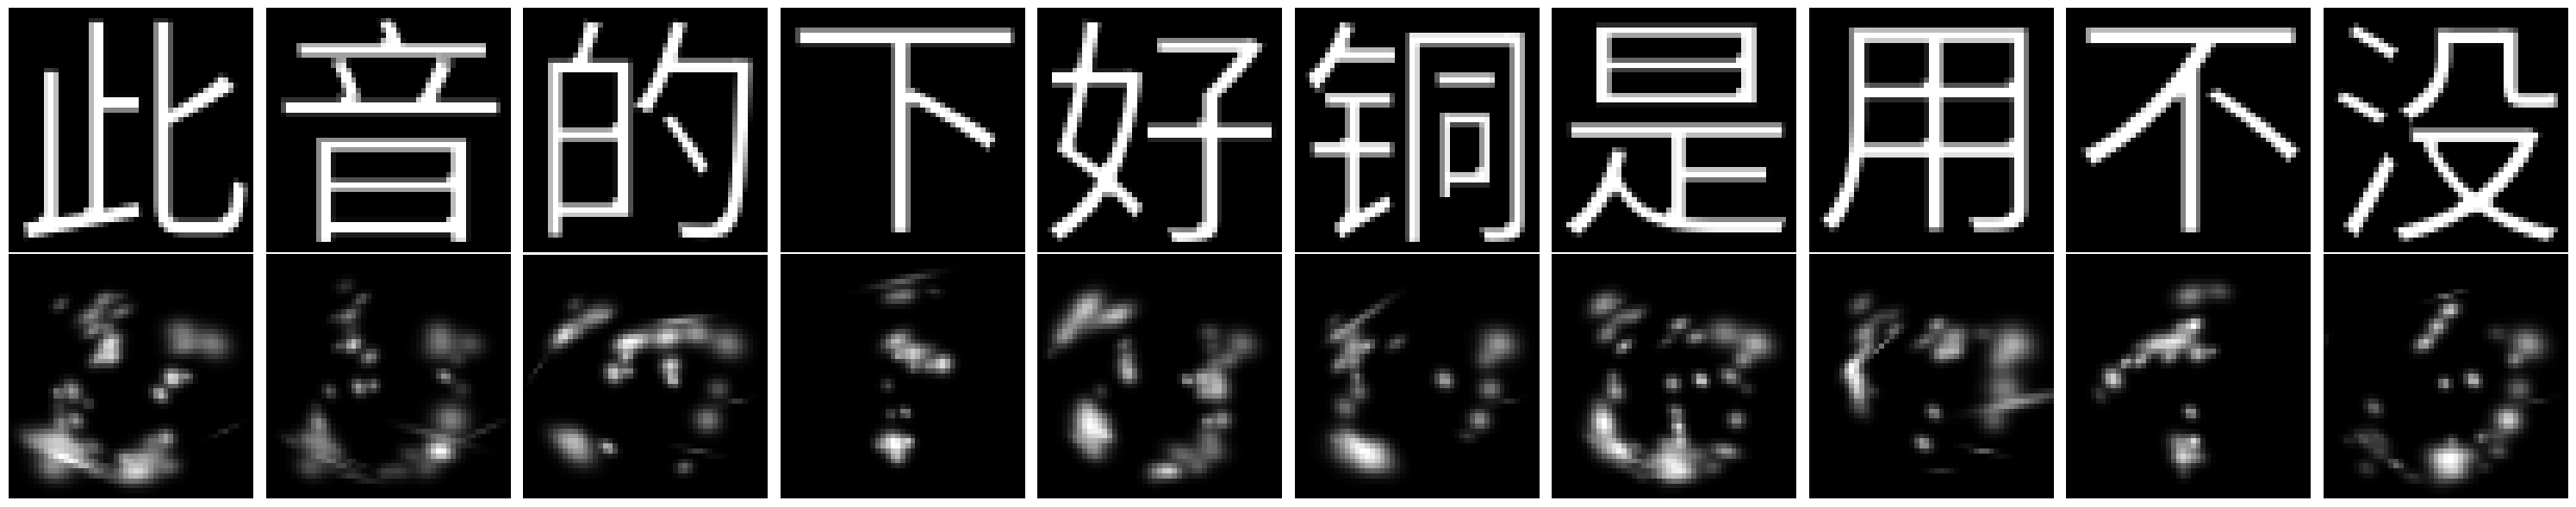

In [34]:
nimgs = 10
predicted_percepts = patient.mismatch_dse([targets_test[:nimgs], tf.repeat(best_phi[None, ...], nimgs, axis=0)])
fig, axes = plt.subplots(2, nimgs, figsize=(nimgs*3, 6))
for idx, (pred, target) in enumerate(zip(predicted_percepts, targets_test[:nimgs])): 
    axes[0, idx].imshow(target, cmap='gray')
    axes[1, idx].imshow(pred, cmap='gray')
# make it look nice
for ax in axes.ravel():
    ax.axis('off')
fig.tight_layout()